## Initiate SparkContext

In [37]:
sc

## Import Music Data

In [38]:
import json
songs = sc.textFile("/Users/Edyue/spark-1.3.0-bin-hadoop2.4/new-songs.mp3.base64.json", 100).cache()

## Process & Display songs

In [41]:
import base64
from io import BytesIO
import numpy as np
from pydub import AudioSegment

def audio_segment_to_samples(data):
    audio = AudioSegment.from_mp3(BytesIO(base64.b64decode(data)))
    wave = audio.export('_', format='wav')
    wave.seek(0)
    return np.frombuffer(wave.read(), np.int16)[24:] / 2.**15

def audio_segment_in_ipython(song_data):
    from IPython.core.display import HTML, display
    display(HTML("""<audio controls="controls" style="width:600px" >
        <source controls
            src="data:audio/mp3;base64,{}" type="audio/mp3" />
      </audio>""".format(song_data)))

### Test on a short segment 

In [42]:
song_piece = songs.map(lambda x: json.loads(x)["data"]).first()

In [43]:
audio_segment_in_ipython(song_piece)

### Test on an entire song

In [24]:
song_5 = songs.map(lambda x: json.loads(x)).filter(lambda x: x["song_id"] == 5).collect()

In [25]:
sounds = map((lambda x: AudioSegment.from_mp3(BytesIO(base64.b64decode(x["data"])))), song_5)

In [26]:
overall_sound = reduce(lambda a, b: a + b, sounds)

In [27]:
overall_sound.export('test.mp3', format='mp3')

<open file 'test.mp3', mode 'wb+' at 0x107454f60>

In [29]:
audio_segment_in_ipython(base64.b64encode(open("test.mp3").read()))

# convert samples into a spectrogram

In [30]:
data = base64.b64encode(open("test.mp3").read())

In [33]:
import matplotlib.mlab as mlab
from scipy.ndimage.filters import maximum_filter
import numpy as np

def hash_a_song(samples):
    ft_graph = mlab.specgram(samples, scale_by_freq=False)[0]
      # Don't rescale by 1/f!


    maxes = (maximum_filter(ft_graph, size=10) == ft_graph) & \
              (ft_graph > -150)
      # Compute relative maxima 20 units away from others, where
      # intensity is greater than -150 dB.


    freqs, times = np.where(maxes)
    return (freqs, times)

In [34]:
samples = audio_segment_to_samples(data)
hashes = hash_a_song(samples)

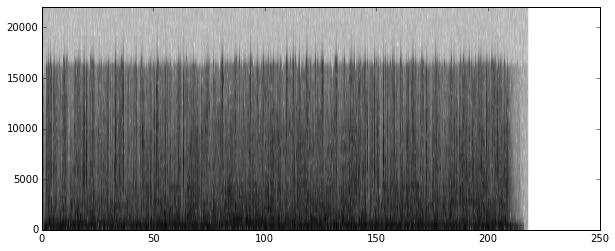

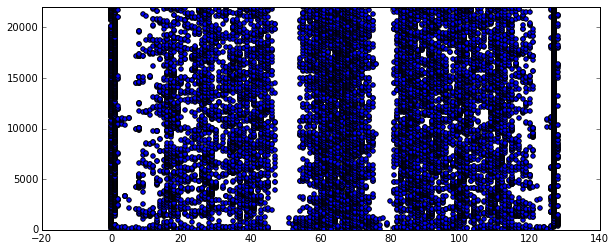

In [48]:
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib.cm import get_cmap
import numpy as np

plt.figure(figsize=(10, 4))
plt.specgram(audio_segment_to_samples(data), Fs=2*44100, cmap=get_cmap('Greys'))
# plt.xlim(0, 50)
plt.ylim(0, 22050)
plt.show()

plt.figure(figsize=(10, 4))
plt.scatter(*hash_a_song(samples))
# plt.xlim(0, 50)
plt.ylim(0, 22050)
plt.show()
None